<a href="https://colab.research.google.com/github/gwillig/dreambooth/blob/main/Experience_with_dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dreambooth Personalized Image Generation


The following Notebook shows some experience with dreambooth. 
To goal was to create images which could be used on linkedin or for a CV.


## 1. Setup


In [ ]:
# Lib to remove the background from the images
!pip install rembg
# Install diffusers 
!git clone https://github.com/ShivamShrirao/diffusers

%cd diffusers/
!pip install -e .

# For GPU efficiency
!pip install bitsandbytes

# Install dreambooth requirements
%cd /content/diffusers/examples/dreambooth/
!pip install -r requirements.txt

# Accelerate environment
!accelerate config default

## 2. Upload images

In [ ]:
%cd /content
print("Upload your images into the folder images_raw")
!mkdir images
!mkdir images_raw
!mkdir generated_images

/content
Make sure you put the images into the newly created directory!


In [ ]:
# Removes the background of the images 
from rembg import remove
from PIL import Image
import os 

input_path =  os.getcwd()+r"/images_raw"
image_files = os.listdir(input_path)

#Removes from all uploaded images the backgrounff
for el in image_files:

  input_path =  os.getcwd()+r"/images_raw/"+el
  el_name = el.split(".")[0]
  output_path = os.getcwd()+r"/images/"+el_name+".png"
    
  # Processing the image
  input = Image.open(input_path)
    
  # Removing the background from the given Image
  output = remove(input)
    
  #Saving the image without the background
  output.save(output_path)
  output

## 3. Fine-tuning

Below you can find the explaination of the most improtant args 

| Argument | Description | 
| --- | --- | 
| instance_data_dir | Directory of the sample images |
| instance_prompt | Prompt with the special token like [V], zwx, sks... | 
| with_prior_preservation | Used to avoid overfitting and language-drift |
| num_class_images | Number of generated images (prior) |
| class_prompt | Used together with prior preservation - type of generated samples to avoid prior loss | 
| use_8bit_adam | Quantized optimizer to reduce GPU memory (from bitsandbytes using reduced precision) | 
| mixed_precision | Another accelerator to reduce data type precision |
| pretrained_vae_name_or_path | Custom autoencoder to improve eyes and faces |

The values for the args has been estimated by try and error 



In [14]:
%cd /content
%env MODEL_NAME=runwayml/stable-diffusion-v1-5
%env INSTANCE_DIR=/content/images_raw/
%env OUTPUT_DIR=outputs/
%env CLASS_DIR=/content/diffusers/examples/dreambooth/person/


!accelerate launch diffusers/examples/dreambooth/train_dreambooth.py \
    --pretrained_model_name_or_path=$MODEL_NAME  \
    --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
    --instance_data_dir=$INSTANCE_DIR \
    --output_dir=$OUTPUT_DIR \
    --class_data_dir=$CLASS_DIR \
    --with_prior_preservation --prior_loss_weight=1.0 \
    --instance_prompt="photo of gustav person" \
    --class_prompt="photo of person" \
    --resolution=512 \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 --gradient_checkpointing \
    --use_8bit_adam \
    --mixed_precision="fp16" \
    --learning_rate=1e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --num_class_images=300 \
    --max_train_steps=1000

/content
env: MODEL_NAME=runwayml/stable-diffusion-v1-5
env: INSTANCE_DIR=/content/images_raw/
env: OUTPUT_DIR=outputs/
env: CLASS_DIR=/content/diffusers/examples/dreambooth/person/
2023-04-10 16:11:17.242544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-10 16:11:21.776764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.9/dist-packages/accelerate/accelerator.py:249: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage(

## Generation

In [15]:
# Installing diffusers again because there are some issues for loading the StableDiffusionPipeline
!pip install -e diffusers
print("Restart the runtime!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.15.0.dev0-0.editable-py3-none-any.whl size=11106 sha256=5e716e01af8398f6ef51d30ffb4f6e2c8f5b339bc1ed876f53db273464d38577
  Stored in directory: /tmp/pip-ephem-wheel-cache-ezzkw58r/wheels/bd/1c/ea/a9c409b587aa6f3abca1bf1ce8eb592b2b541e5f26f5a4f44b
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0.dev0
    Uninstalling diffusers-0.15.0.dev0:
      Successfully uninstalled diffusers-0.15.0.dev0


Restart the runtime!


In [1]:
%cd /content
import torch
import random
from diffusers import StableDiffusionPipeline
model_id = "outputs/1000"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")


/content


/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

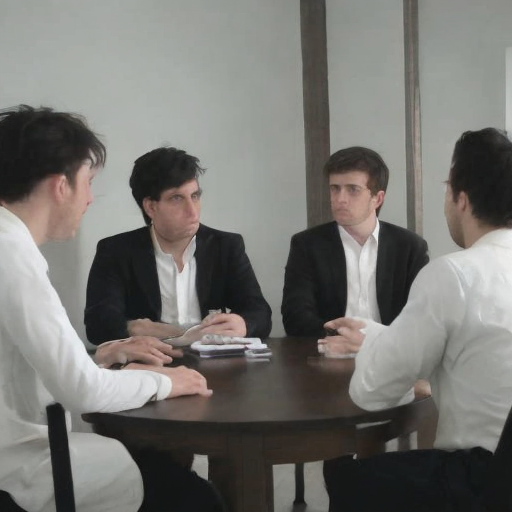

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from IPython.display import Image, display, HTML


example_prompts = [
" clean shaved gustav person" ,
" gustav person in a suit" ,
" CV photo of gustav person in a suit" ,
"LinkedIn picture of gustav person in a suit" ,
"gustav person in a meeting" ,
"gustav person in modern office" ,
]

num_images = len(example_prompts)
for i in range(num_images):
    prompt = example_prompts[random.randint(0, len(example_prompts) - 1)]
    image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    #image.save(f"generated_images/{i}_profile_{prompt}.png")
    display(HTML(f"<h3>{prompt}</h3>"))
    display(image)
